In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
import os
import sys
import itertools
import imageio
import random
import numpy as np
import copy
import cv2

import mot3d
from mot3d.utils import utils
from mot3d.utils import trajectory as utils_traj
from mot3d.weight_functions import (weight_distance_detections_2d, weight_confidence_detections_2d,\
                                    weight_distance_tracklets_2d, weight_confidence_tracklets_2d)   

sys.path.append("../")
from tracking_routines import *
import feeders

In [33]:
config_file = "../config/config_singleview_PETS2009S2L1_View_001.yaml"
__c__ = utils.yaml_read(config_file)

In [34]:
__cfgd__ = copy.deepcopy(__c__['tracking']['detections'])
__cfgd__

{'weight_source_sink': 1,
 'max_jump': 4,
 'verbose': True,
 'weight_distance': {'sigma_distance': 10,
  'sigma_jump': 4,
  'sigma_color_histogram': 0.1,
  'sigma_box_size': 0.1,
  'max_distance': 30,
  'use_color_histogram': True,
  'use_bbox': True},
 'weight_confidence': {'mul': 0, 'bias': 0}}

In [ ]:
__cfgd__['max_jump']=4
__cfgd__['weight_distance']['sigma_distance']=1000
__cfgd__['weight_distance']['sigma_jump']=1
__cfgd__['weight_distance']['use_color_histogram']=False
__cfgd__['weight_distance']['use_bbox']=False

In [35]:
__Detection__ = mot3d.Detection2D

weight_distance_d = lambda d1, d2 : weight_distance_detections_2d(d1, d2, **__cfgd__['weight_distance'])
weight_confidence_d = lambda d : weight_confidence_detections_2d(d, **__cfgd__['weight_confidence'])        
__compute_trajs__ = lambda detections: compute_trajectories(detections, 
                                                            weight_source_sink=__cfgd__['weight_source_sink'], 
                                                            weight_distance=weight_distance_d, 
                                                            weight_confidence=weight_confidence_d,
                                                            max_jump=__cfgd__['max_jump'],
                                                            verbose=__cfgd__['verbose'])

In [36]:
feeder_name = __c__['feeder']['name']
object_class = __c__['feeder'][feeder_name]['object_class']
feeder = feeders.Feeder[feeder_name](**__c__['feeder'][feeder_name])
iterator = iter(feeder)

In [37]:
batch_size = 500

feeder.idx = 50

indexes = []
detections = []
for _ in range(batch_size):
    try:
        _idx,_detections = next(iterator)
        indexes.append(_idx)
        detections.append(_detections)
    except StopIteration:
        done = True   
        break

print("Batch size: {} from index {} to {}".format(len(detections), indexes[0], indexes[-1]))

Batch size: 500 from index 51 to 550


In [38]:
tracklets = __compute_trajs__(detections)

  2%|▏         | 138/5900 [00:00<00:04, 1379.90it/s]

Number of frames: 500
Number of detections: 2949


100%|██████████| 5900/5900 [00:03<00:00, 1680.92it/s]


Number of post-pre nodes edges created: 14056
Fraction of edges per detection: 7.766361478467277
Graph solved in 0.2604s using muSSP.


In [15]:
tracklet_splits = []
for tracklet in tracklets:
    tracklet = utils_traj.interpolate_trajectory(tracklet, attr_names=['position'])
    tracklet_splits += utils_traj.split_trajectory_modulo(tracklet, length=5)

tracklets = utils_traj.remove_short_trajectories(tracklet_splits, th_length=2)

<IPython.core.display.Javascript object>


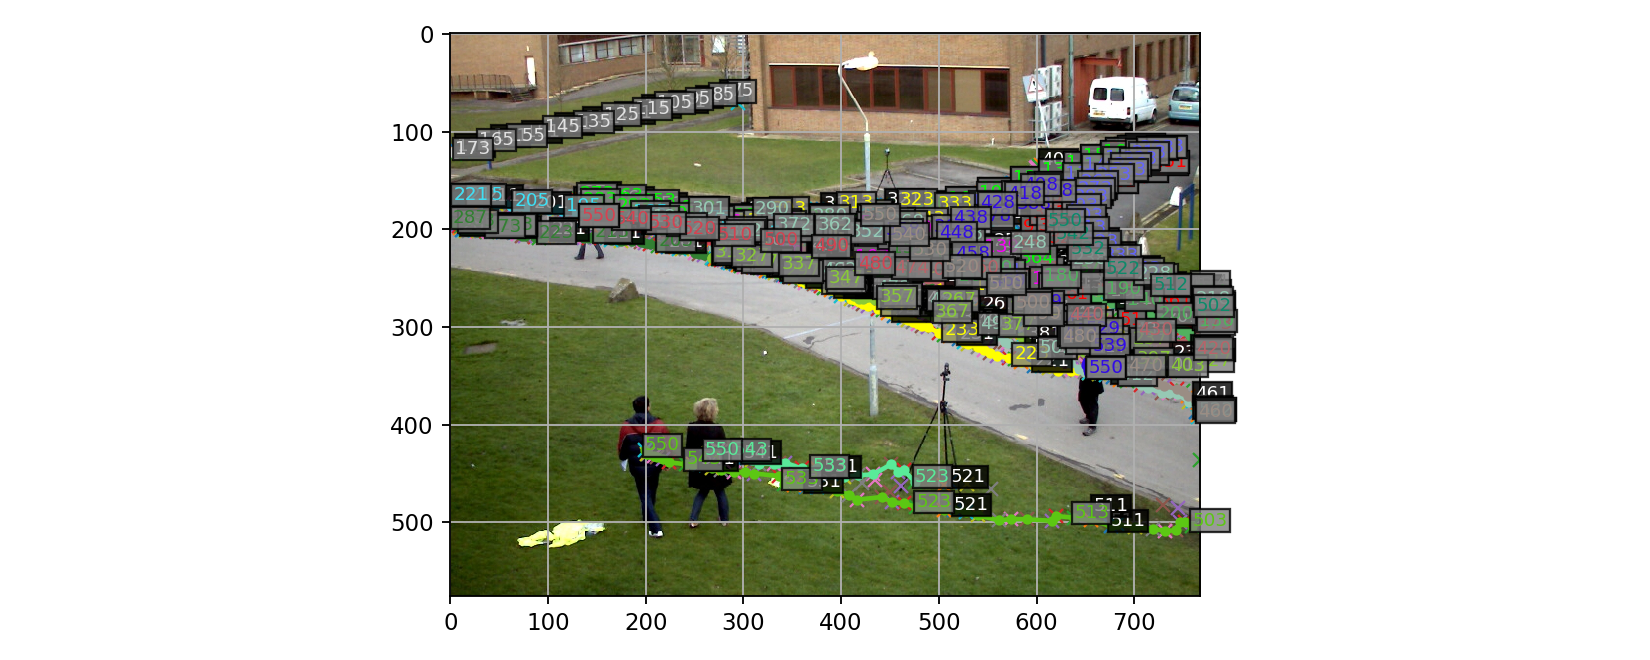

Batch size: 500
0 start_idx:51 end_idx:373 lenght:323 start_pos:[685.47227568 298.26341337]
1 start_idx:51 end_idx:395 lenght:342 start_pos:[520.78527653 251.18957699]
2 start_idx:51 end_idx:365 lenght:313 start_pos:[561.79034783 248.29924191]
3 start_idx:51 end_idx:352 lenght:298 start_pos:[386.8163147  209.86300839]
4 start_idx:51 end_idx:93 lenght:43 start_pos:[419.15531114 211.74455441]
5 start_idx:51 end_idx:150 lenght:92 start_pos:[418.58896233 199.16259855]
6 start_idx:75 end_idx:173 lenght:99 start_pos:[286.54744945  63.91378044]
7 start_idx:100 end_idx:105 lenght:6 start_pos:[438.7064945  207.64575016]
8 start_idx:114 end_idx:148 lenght:34 start_pos:[760.16663675 259.06424938]
9 start_idx:116 end_idx:287 lenght:165 start_pos:[427.76541497 203.65937267]
10 start_idx:130 end_idx:210 lenght:81 start_pos:[766.76391602 298.81332936]
11 start_idx:155 end_idx:221 lenght:67 start_pos:[406.67252664 206.80008204]
12 start_idx:218 end_idx:522 lenght:301 start_pos:[762.50290456 276.146028

In [39]:
plt.figure(figsize=(10,4))

img = feeder.get_image(feeder.idx-1)
plt.imshow(img)

if True:  
    display_time_every = 10
    
    for dets in detections:
        if len(dets):
            ps = np.array([d.position for d in dets])
            plt.plot(ps[:,0], ps[:,1], 'x')

    for dets in detections[::display_time_every]:    
        positions = np.array([d.position for d in dets])
        times = np.array([d.index for d in dets])
        for (x,y),time in zip(positions, times):
            plt.text(x,y, str(time), color=[1,1,1], fontsize=8, 
                     bbox={'facecolor': 'black', 'alpha': 0.8, 'pad': 1})    

mot3d.plot_trajectories(tracklets, display_time=True, display_time_every=10)

print("Batch size: {}".format(len(detections)))
for i,tracklet in enumerate(tracklets):
    print("{} start_idx:{} end_idx:{} lenght:{} start_pos:{}".format(i, tracklet[0].index, 
                                                                     tracklet[-1].index,
                                                                     len(tracklet),
                                                                     tracklet[0].position))
plt.tight_layout()